# API Project
Comparing various Noise Reduction Techniques with each other using various kinds of metrics

### Technique 1 STFT

In [30]:
import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile
import time
from datetime import timedelta as td

In [31]:
def fftnoise(f):
    f = np.array(f, dtype="complex")
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1: Np + 1] *= phases
    f[-1: -1 - Np: -1] = np.conj(f[1: Np + 1])
    return np.fft.ifft(f).real

In [32]:

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1 / samplerate))
    f = np.zeros(samples)
    f[np.logical_and(freqs >= min_freq, freqs <= max_freq)] = 1
    return fftnoise(f)
    

In [33]:

def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    

In [34]:

def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length=hop_length, win_length=win_length)


def _amp_to_db(x):
    return librosa.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x):
    return librosa.db_to_amplitude(x, ref=1.0)
    

def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.show()
    

In [35]:

def plot_statistics_and_filter(mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    ax[0].plot(std_freq_noise, label="Std. power of noise")
    ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()
    


In [36]:

def remove_noise(
    audio_clip, 
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=512,
    win_length=512,
    hop_length=512//4,
    n_std_thresh=0.5,
    prop_decrease=0.8,
    verbose=False,
    visual=False,
):
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))

    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh

    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))

    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))

    smoothing_filter = np.outer(
        np.concatenate([
            np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
            np.linspace(1, 0, n_grad_freq + 2),
        ])[1:-1],
        np.concatenate([
            np.linspace(0, 1, n_grad_time + 1, endpoint=False),
            np.linspace(1, 0, n_grad_time + 2),
        ])[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)

    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T

    sig_mask = sig_stft_db < db_thresh
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease

    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (1j * sig_imag_masked)

    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )

    if verbose:
        plot_spectrogram(noise_stft_db, 'Noise STFT (dB)')
        plot_spectrogram(recovered_spec, 'Recovered Spectrogram (dB)')
    
    return recovered_signal
    

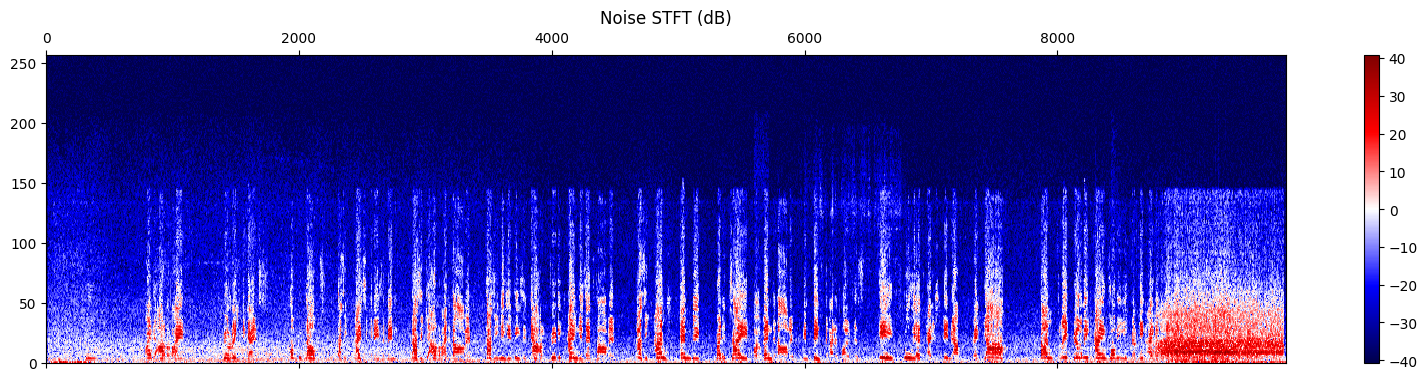

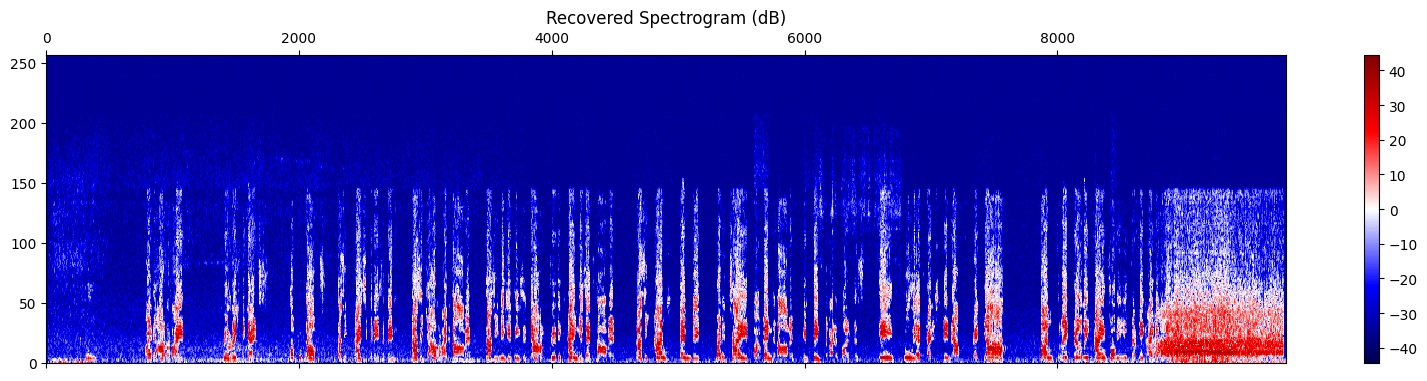

In [37]:

if __name__ == "__main__":
    wav_loc = 'in.wav'
    data, sr = librosa.load(wav_loc, sr=None)
    denoised = remove_noise(data, data, verbose=True, visual=True)
    soundfile.write('denoised-stft.wav', denoised, sr)
    

### Technique 2 FFT + DNN

/tmp/ipykernel_298584/2682131093.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  snr = 10 * np.log10(signal_power / noise_power)


Original SNR: inf dB
Filtered SNR: 5.84 dB


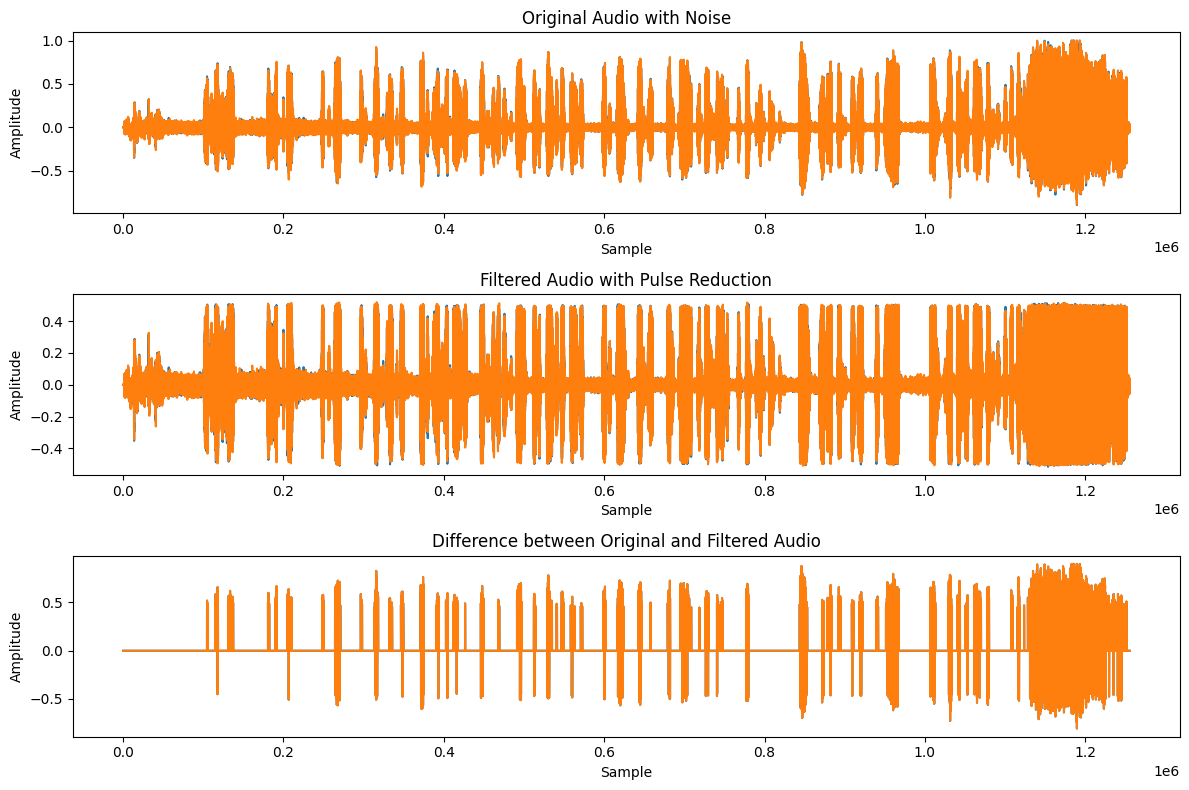

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.fft import fft, ifft

def calculate_snr(clean, noisy):
    signal_power = np.sum(clean ** 2) / len(clean)
    noise_power = np.sum((clean - noisy) ** 2) / len(clean)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

audio, sample_rate = sf.read('in.wav')

audio_fft = fft(audio)

cutoff_frequency = 2000
num_samples = len(audio)
frequency_indices = np.fft.fftfreq(num_samples, d=1/sample_rate)

high_amplitude_indices = np.abs(audio_fft) > np.percentile(np.abs(audio_fft), 99)
audio_fft[high_amplitude_indices] *= 0.1

filtered_audio = np.real(ifft(audio_fft))

sf.write('denoise-fft.wav', filtered_audio, sample_rate)

original_snr = calculate_snr(audio, audio)
filtered_snr = calculate_snr(audio, filtered_audio)

print(f'Original SNR: {original_snr:.2f} dB')
print(f'Filtered SNR: {filtered_snr:.2f} dB')

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(audio)
plt.title('Original Audio with Noise')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 2)
plt.plot(filtered_audio)
plt.title('Filtered Audio with Pulse Reduction')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(3, 1, 3)
plt.plot(audio - filtered_audio)
plt.title('Difference between Original and Filtered Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
import keras
import scipy.io.wavfile
import scipy.signal
import os
import random
from pathlib import Path
from sphfile import SPHFile


2024-12-15 18:09:37.172958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734282577.206550  298584 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734282577.214466  298584 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 18:09:37.242957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Define the stackLayers function
def stackLayers(layerSet):
    stack = layerSet[0]
    for i in range(1, len(layerSet)):
        stack = layerSet[i](stack)
    return stack


In [9]:
# Set the working directory for TIMIT dataset
train_cwd = './TIMIT/TRAIN'  # Adjust path to TIMIT training data
test_cwd = './TIMIT/TEST'    # Adjust path to TIMIT test data

# Load the training dataset (TIMIT)
trainSoundClips = []
print(f"Loading training data from: {train_cwd}")
for soundFile in Path(train_cwd).rglob('*.wav'):
    trainSoundClips += [scipy.io.wavfile.read(soundFile)]

# Load the testing dataset (TIMIT)
testSoundClips = []
print(f"Loading testing data from: {test_cwd}")
for soundFile in Path(test_cwd).rglob('*.wav'):
    testSoundClips += [scipy.io.wavfile.read(soundFile)]

# Assuming the dataset rate is the same for all files
dataRate = trainSoundClips[0][0]

# Extracting audio data from the loaded clips
trainClips = [i[1] for i in trainSoundClips]
testClips = [i[1] for i in testSoundClips]

# Merge training data and validation split (90% training, 10% validation)
mergedSpeech = np.concatenate(trainClips, axis=0)
validationSpeech = mergedSpeech[mergedSpeech.shape[0] * 9 // 10:]
mergedSpeech = mergedSpeech[:mergedSpeech.shape[0] * 9 // 10]

normalizingFactor = np.std(mergedSpeech)
noisingFactor = 0.15  # Can adjust based on noise level
clipLength = 1024

Loading training data from: ./TIMIT/TRAIN
Loading testing data from: ./TIMIT/TEST


In [10]:
# Define the sampleGenerator function
def sampleGenerator(originalSound, sampleLength, noisingFactor, normalizingFactor, batchSize=32, firstFixed=None):
    while True:
        indices = np.random.randint(low=0, high=originalSound.shape[0] - sampleLength, size=batchSize).tolist()
        if firstFixed is not None:
            indices[0] = firstFixed
        samples = np.array([originalSound[index:index + sampleLength] for index in indices])
        noise = np.random.normal(loc=0, scale=noisingFactor * normalizingFactor, size=samples.shape)
        yield ((samples + noise) / normalizingFactor, samples / normalizingFactor)


In [11]:
# Define the model layers (already provided in the code)
denoiserLayers = [
    keras.layers.Input(shape=(clipLength,)),
    keras.layers.Reshape((clipLength, 1)),

    keras.layers.Conv1D(filters=64, kernel_size=25, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv1D(filters=64, kernel_size=25, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(.4),

    keras.layers.Conv1D(filters=64, kernel_size=25, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv1D(filters=64, kernel_size=25, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(.4),

    keras.layers.Conv1D(filters=64, kernel_size=25, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv1D(filters=64, kernel_size=25, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(.4),

    keras.layers.Conv1D(filters=64, kernel_size=25, padding='same'),
    keras.layers.LeakyReLU(),

    keras.layers.Conv1D(filters=1, kernel_size=25, padding='same'),
    keras.layers.Dropout(.4),

    keras.layers.Reshape((clipLength,)),
]

# Now you can use stackLayers function to build the model
denoiser = keras.models.Model(inputs=denoiserLayers[0], outputs=stackLayers(denoiserLayers))
denoiser.compile(optimizer=keras.optimizers.Adam(.0001, decay=1e-7), loss='mse', metrics=['mse'])
denoiser.summary()


I0000 00:00:1734282651.352104  298584 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5464 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1
/home/noshamedevil/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1024, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1024, 64)       │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1024, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1024, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1024, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1024, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1024, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 1024, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 1024, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1024, 1)        │         1,601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1024)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 618,049 (2.36 MB)

 Trainable params: 618,049 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Train the model
clipGenerator = sampleGenerator(mergedSpeech, clipLength, noisingFactor, normalizingFactor, batchSize=32)
validationClipGenerator = sampleGenerator(validationSpeech, clipLength, noisingFactor, normalizingFactor, batchSize=256)

# Train the model
# Train the model without multiprocessing
denoiser.fit(clipGenerator, 
              steps_per_epoch=512, 
              epochs=20, 
              validation_data=validationClipGenerator, 
              validation_steps=16,
              verbose=2)



Epoch 1/20


I0000 00:00:1734282660.254175  306997 service.cc:148] XLA service 0x7f69e8001eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734282660.254208  306997 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2024-12-15 18:11:00.370203: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734282660.840656  306997 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-15 18:11:06.618473: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_transpose_fusion_6', 8 bytes spill stores, 96 bytes spill loads

I0000 00:00:1734282666.662080  306997 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


512/512 - 36s - 71ms/step - loss: 0.4298 - mse: 0.4298 - val_loss: 0.1561 - val_mse: 0.1561
Epoch 2/20
512/512 - 24s - 47ms/step - loss: 0.4217 - mse: 0.4217 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 3/20
512/512 - 25s - 49ms/step - loss: 0.4217 - mse: 0.4217 - val_loss: 0.1366 - val_mse: 0.1366
Epoch 4/20
512/512 - 31s - 60ms/step - loss: 0.4085 - mse: 0.4085 - val_loss: 0.1310 - val_mse: 0.1310
Epoch 5/20
512/512 - 38s - 75ms/step - loss: 0.4348 - mse: 0.4348 - val_loss: 0.1234 - val_mse: 0.1234
Epoch 6/20
512/512 - 47s - 92ms/step - loss: 0.4133 - mse: 0.4133 - val_loss: 0.1490 - val_mse: 0.1490
Epoch 7/20
512/512 - 55s - 107ms/step - loss: 0.4110 - mse: 0.4110 - val_loss: 0.1433 - val_mse: 0.1433
Epoch 8/20
512/512 - 60s - 118ms/step - loss: 0.4062 - mse: 0.4062 - val_loss: 0.1474 - val_mse: 0.1474
Epoch 9/20
512/512 - 67s - 130ms/step - loss: 0.4152 - mse: 0.4152 - val_loss: 0.1513 - val_mse: 0.1513
Epoch 10/20
512/512 - 69s - 135ms/step - loss: 0.4071 - mse: 0.4071 - val_loss: 0

In [13]:
# Test the model on a noisy clip from the test dataset
def sequentialPredict(data, subsequenceLength, stride):
    assert stride <= subsequenceLength
    batchSize = 32
    batchedData = np.empty((int(np.ceil(data.shape[0] - subsequenceLength) / stride) + 1, subsequenceLength))
    startIndices = np.empty((batchedData.shape[0],), dtype=np.int32)
    for i in range(0, batchedData.shape[0]):
        startIndex = i * stride
        if startIndex > data.shape[0] - subsequenceLength:
            startIndex = data.shape[0] - subsequenceLength
        batchedData[i] = data[startIndex:startIndex + subsequenceLength] / normalizingFactor
        startIndices[i] = startIndex
    processedBatches = denoiser.predict(batchedData, batch_size=batchSize) * normalizingFactor

    finalData = np.zeros(data.shape)
    hitCounter = np.zeros(data.shape)
    for i in range(0, batchedData.shape[0]):
        finalData[startIndices[i]:startIndices[i] + subsequenceLength] += processedBatches[i]
        hitCounter[startIndices[i]:startIndices[i] + subsequenceLength] += 1
    finalData = np.divide(finalData, hitCounter)
    return finalData.astype(np.int16)

testClip = testClips[0]  # Choose a clip from the test set
noisedClip = (testClip + np.random.normal(loc=0, scale=noisingFactor * normalizingFactor, size=testClip.shape)).astype(np.int16)

# Denoise the clip
predicted = sequentialPredict(noisedClip, clipLength, stride=clipLength // 2)

# Save the denoised output
scipy.io.wavfile.write("predicted_test.wav", dataRate, predicted)
scipy.io.wavfile.write("original_test.wav", dataRate, testClips[0])
scipy.io.wavfile.write("noised_test.wav", dataRate, noisedClip)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


/home/noshamedevil/miniconda3/envs/tf/lib/python3.10/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


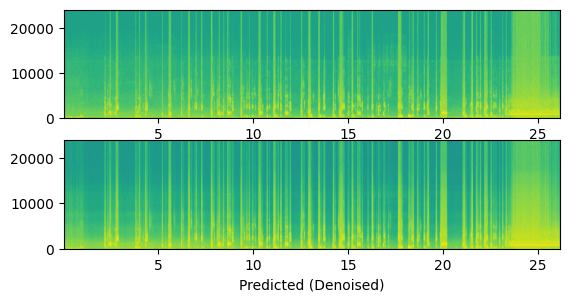

In [16]:
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt

# Function to load your custom .wav file
def load_audio_file(file_path):
    rate, data = scipy.io.wavfile.read("denoise-fft.wav")  # Load the .wav file
    return rate, data

# Function to convert stereo audio to mono
def stereo_to_mono(stereo_audio):
    if len(stereo_audio.shape) == 2:  # Check if audio is stereo
        mono_audio = stereo_audio.mean(axis=1)  # Average the two channels
        return mono_audio.astype(np.int16)  # Convert back to int16 if necessary
    return stereo_audio  # If it's already mono, return it as is

# Load your own noisy .wav file (replace 'your_noisy_file.wav' with your actual file path)
file_path = 'your_noisy_file.wav'  # Replace with the path to your noisy .wav file
dataRate, testClip = load_audio_file(file_path)

# Convert stereo to mono if necessary
testClip = stereo_to_mono(testClip)

# Normalize the audio (optional step)
normalizingFactor = np.std(testClip)

# Denoise the noisy clip using the trained model
predicted = sequentialPredict(testClip, clipLength, stride=clipLength // 2)

# Save the denoised output to a file
scipy.io.wavfile.write("denoised-fft-dnn.wav", dataRate, predicted)
scipy.io.wavfile.write("original_noisy.wav", dataRate, testClip)

# Plot spectrograms to compare original noisy and predicted clips
plt.subplot(311)
plt.specgram(testClip, Fs=dataRate)
plt.xlabel("Original Noisy")

plt.subplot(312)
plt.specgram(predicted, Fs=dataRate)
plt.xlabel("Predicted (Denoised)")

plt.show()


### Technique 3 (DNN only)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


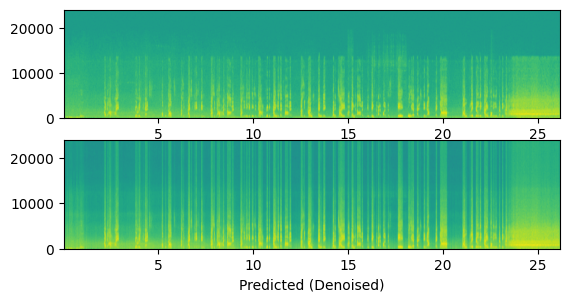

In [17]:
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt

# Function to load your custom .wav file
def load_audio_file(file_path):
    rate, data = scipy.io.wavfile.read("in.wav")  # Load the .wav file
    return rate, data

# Function to convert stereo audio to mono
def stereo_to_mono(stereo_audio):
    if len(stereo_audio.shape) == 2:  # Check if audio is stereo
        mono_audio = stereo_audio.mean(axis=1)  # Average the two channels
        return mono_audio.astype(np.int16)  # Convert back to int16 if necessary
    return stereo_audio  # If it's already mono, return it as is

# Load your own noisy .wav file (replace 'your_noisy_file.wav' with your actual file path)
file_path = 'your_noisy_file.wav'  # Replace with the path to your noisy .wav file
dataRate, testClip = load_audio_file(file_path)

# Convert stereo to mono if necessary
testClip = stereo_to_mono(testClip)

# Normalize the audio (optional step)
normalizingFactor = np.std(testClip)

# Denoise the noisy clip using the trained model
predicted = sequentialPredict(testClip, clipLength, stride=clipLength // 2)

# Save the denoised output to a file
scipy.io.wavfile.write("denoised-dnn.wav", dataRate, predicted)
scipy.io.wavfile.write("original_noisy.wav", dataRate, testClip)

# Plot spectrograms to compare original noisy and predicted clips
plt.subplot(311)
plt.specgram(testClip, Fs=dataRate)
plt.xlabel("Original Noisy")

plt.subplot(312)
plt.specgram(predicted, Fs=dataRate)
plt.xlabel("Predicted (Denoised)")

plt.show()


### Comparing the Techniques

In [ ]:
!pip install pesq pystoi


Comparison Metrics:
Method: STFT
SNR (dB): 5.04
MSE: 0.007240
PESQ: 2.95
STOI: 0.90

Method: FFT+DNN
SNR (dB): 3.94
MSE: 0.009326
PESQ: 1.96
STOI: 0.85

Method: DNN
SNR (dB): 7.22
MSE: 0.004377
PESQ: 3.74
STOI: 0.92

Method: FFT
SNR (dB): 6.13
MSE: 0.005634
PESQ: 2.21
STOI: 0.90



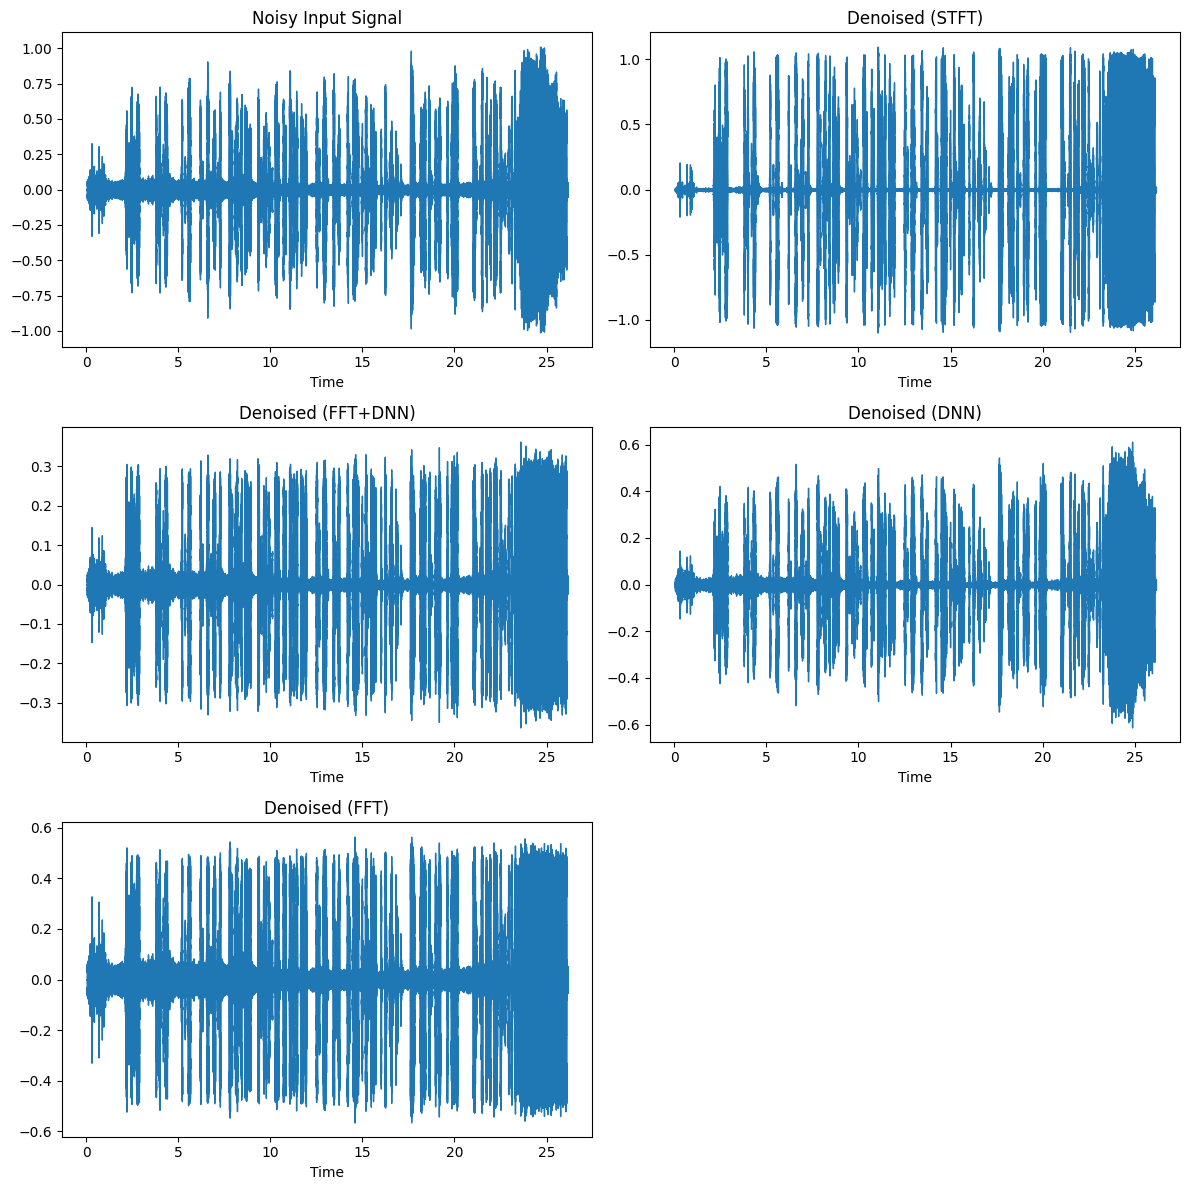

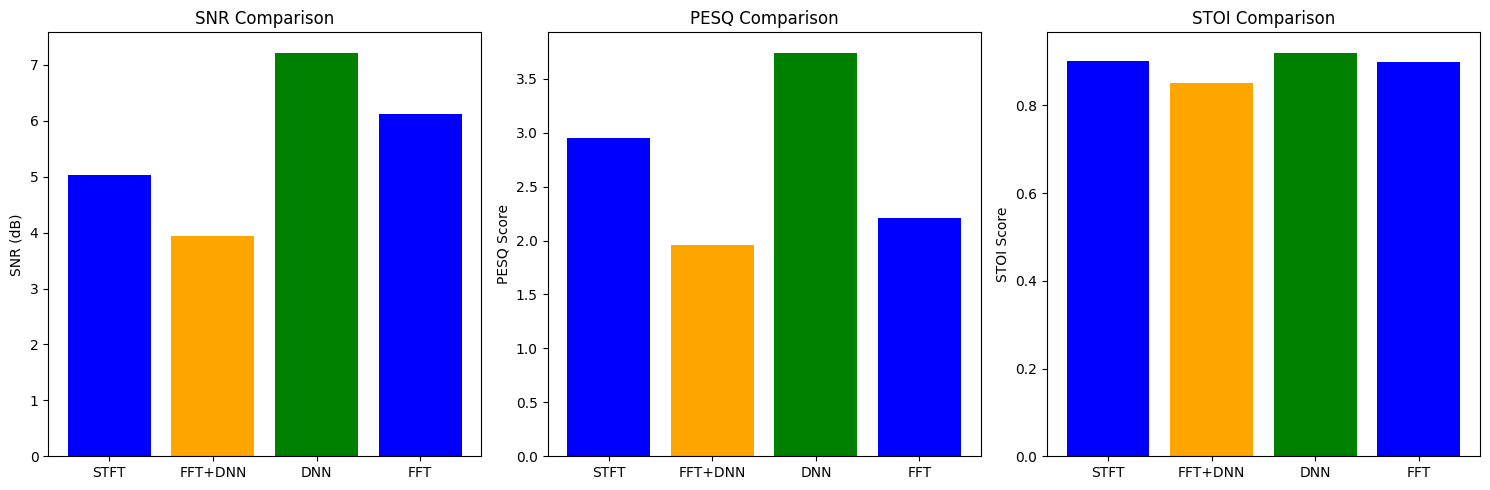

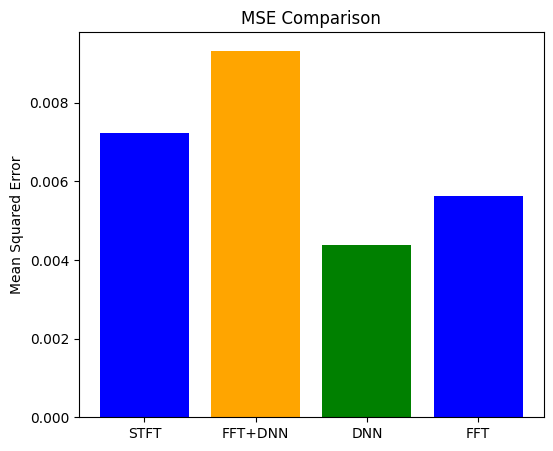

In [19]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io import wavfile
from pesq import pesq  # Install using `pip install pesq`
from pystoi import stoi  # Install using `pip install pystoi`

# Function to calculate Signal-to-Noise Ratio (SNR)
def calculate_snr(original_signal, denoised_signal):
    signal_power = np.sum(original_signal ** 2)
    noise_power = np.sum((original_signal - denoised_signal) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Function to calculate Mean Squared Error (MSE)
def calculate_mse(original_signal, denoised_signal):
    return np.mean((original_signal - denoised_signal) ** 2)

# Function to compare spectrograms
def plot_spectrograms(original, denoised_methods, sr):
    plt.figure(figsize=(12, 12))

    plt.subplot(3, 2, 1)
    librosa.display.waveshow(original, sr=sr)
    plt.title("Noisy Input Signal")

    for i, (method_name, signal) in enumerate(denoised_methods.items(), start=2):
        plt.subplot(3, 2, i)
        librosa.display.waveshow(signal, sr=sr)
        plt.title(f"Denoised ({method_name})")

    plt.tight_layout()
    plt.show()

# Plot comparison graphs
def plot_comparison_graphs(metrics):
    methods = metrics["Method"]

    # Plot SNR, PESQ, and STOI Comparison
    plt.figure(figsize=(15, 5))

    # SNR Comparison
    plt.subplot(1, 3, 1)
    plt.bar(methods, metrics["SNR (dB)"], color=['blue', 'orange', 'green'])
    plt.title("SNR Comparison")
    plt.ylabel("SNR (dB)")

    # PESQ Comparison
    plt.subplot(1, 3, 2)
    plt.bar(methods, metrics["PESQ"], color=['blue', 'orange', 'green'])
    plt.title("PESQ Comparison")
    plt.ylabel("PESQ Score")

    # STOI Comparison
    plt.subplot(1, 3, 3)
    plt.bar(methods, metrics["STOI"], color=['blue', 'orange', 'green'])
    plt.title("STOI Comparison")
    plt.ylabel("STOI Score")

    plt.tight_layout()
    plt.show()

    # Separate MSE Comparison
    plt.figure(figsize=(6, 5))
    plt.bar(methods, metrics["MSE"], color=['blue', 'orange', 'green'])
    plt.title("MSE Comparison")
    plt.ylabel("Mean Squared Error")
    plt.show()

# Load audio files
def load_audio(file_path, target_sr):
    signal, sr = librosa.load(file_path, sr=target_sr)
    return signal, sr

# Main comparison function
def compare_denoising_methods(noisy_file, denoised_files):
    target_sr = 16000  # Standard sampling rate

    # Load noisy audio
    noisy_signal, sr = load_audio(noisy_file, target_sr)

    # Load denoised signals
    denoised_signals = {}
    for method_name, file_path in denoised_files.items():
        denoised_signals[method_name], _ = load_audio(file_path, target_sr)

    # Initialize metrics
    metrics = {"Method": [], "SNR (dB)": [], "MSE": [], "PESQ": [], "STOI": []}

    for method_name, denoised_signal in denoised_signals.items():
        # Align lengths for all metrics
        min_length = min(len(noisy_signal), len(denoised_signal))
        aligned_noisy = noisy_signal[:min_length]
        aligned_denoised = denoised_signal[:min_length]

        snr = calculate_snr(aligned_noisy, aligned_denoised)
        mse = calculate_mse(aligned_noisy, aligned_denoised)
        pesq_score = pesq(target_sr, aligned_noisy, aligned_denoised, "wb")  # WB: Wideband
        stoi_score = stoi(aligned_noisy, aligned_denoised, target_sr)

        metrics["Method"].append(method_name)
        metrics["SNR (dB)"].append(snr)
        metrics["MSE"].append(mse)
        metrics["PESQ"].append(pesq_score)
        metrics["STOI"].append(stoi_score)

    # Display metrics
    print("\nComparison Metrics:")
    for i in range(len(metrics["Method"])):
        print(f"Method: {metrics['Method'][i]}\n"
              f"SNR (dB): {metrics['SNR (dB)'][i]:.2f}\n"
              f"MSE: {metrics['MSE'][i]:.6f}\n"
              f"PESQ: {metrics['PESQ'][i]:.2f}\n"
              f"STOI: {metrics['STOI'][i]:.2f}\n")

    # Plot spectrograms
    plot_spectrograms(noisy_signal, denoised_signals, sr)

    # Plot comparison graphs
    plot_comparison_graphs(metrics)

# Example usage
noisy_file = "in.wav"  # Path to the noisy input file
denoised_files = {
    "STFT": "denoised-stft.wav",
    "FFT+DNN": "denoised-fft-dnn.wav",
    "DNN": "denoised-dnn.wav",
    "FFT": "denoise-fft.wav",
}

compare_denoising_methods(noisy_file, denoised_files)
